In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 20;


<IPython.core.display.Javascript object>

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly as py
import plotly.graph_objs as go
import plotly.express as px
import time
import pygwalker as pyg

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score, roc_auc_score, classification_report
from yellowbrick.model_selection import FeatureImportances

import matplotlib.ticker as mtick # For specifying the axes tick format 
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style = 'white')

In [3]:
# data = pd.read_csv("../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv", index_col='customerID')
data = pd.read_csv("../input/advertising.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 78.2+ KB


In [4]:
data.head()

Daily Time Spent on Site  Age  Area Income  Daily Internet Usage  \
0                     68.95   35     61833.90                256.09   
1                     80.23   31     68441.85                193.77   
2                     69.47   26     59785.94                236.50   
3                     74.15   29     54806.18                245.89   
4                     68.37   35     73889.99                225.58   

                           Ad Topic Line            City  Male     Country  \
0     Cloned 5thgeneration orchestration     Wrightburgh     0     Tunisia   
1     Monitored national standardization       West Jodi     1       Nauru   
2       Organic bottom-line service-desk        Davidton     0  San Marino   
3  Triple-buffered reciprocal time-frame  West Terrifurt     1       Italy   
4          Robust logistical utilization    South Manuel     0     Iceland   

             Timestamp  Clicked on Ad  
0  2016-03-27 00:53:11              0  
1  2016-04-04 01:39:02              0  
2  2016-03-13 20:35:42              0  
3  2016-01-10 02:31:19              0  
4  2016-06-03 03:36:18              0

In [5]:
def dataoveriew(df, message):
    print(f'{message}:\n')
    print("Rows:", df.shape[0])
    print("\nNumber of features:", df.shape[1])
    print("\nFeatures:")
    print(df.columns.tolist())
    print("\nMissing values:", df.isnull().sum().values.sum())
    print("\nUnique values:")
    print(df.nunique())

In [6]:
dataoveriew(data, 'Overview of the dataset')

Overview of the dataset:

Rows: 1000

Number of features: 10

Features:
['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country', 'Timestamp', 'Clicked on Ad']

Missing values: 0

Unique values:
Daily Time Spent on Site     900
Age                           43
Area Income                 1000
Daily Internet Usage         966
Ad Topic Line               1000
City                         969
Male                           2
Country                      237
Timestamp                   1000
Clicked on Ad                  2
dtype: int64


View profile report to get more insight

In [7]:
# import pandas_profiling as pp
import ydata_profiling as pp

profile = pp.ProfileReport(data)
profile


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### About Dataset

This data set contains the following features:

#### Variables

* 'Daily Time Spent on Site': consumer time on site in minutes
* 'Age': customer age in years
* 'Area Income': Avg. Income of geographical area of consumer
* 'Daily Internet Usage': Avg. minutes a day consumer is on the internet
* 'Ad Topic Line': Headline of the advertisement
* 'City': City of consumer
* 'Male': Whether or not consumer was male
* 'Country': Country of consumer
* 'Timestamp': Time at which consumer clicked on Ad or closed window
* 'Clicked on Ad': 0 or 1 indicated clicking on Ad

# Feature Engineering: Picking preprocessing method
## Numerical values
* Using RobustScaler (median = 0, interquartile range (IQR) = 1) instead of StandardScaler (mean=0, std=1)

    Because tennure, monthlycharge, totalchanges are not gaussian distribution
    
## Categorical values
* OneHotEncoder

## Boolean values
* LabelEncoder

In [29]:
# Separate all binary + Categorical Values + Boolean values
#target column
target_col = ["Clicked on Ad"]
X = data.copy()

#Binary columns with 2 values
# ['Male']
bin_cols = [x for x in X.nunique()[X.nunique() == 2].keys().tolist() if x not in target_col]
bin_cols

#categorical columns
#number of levels in feature to be a categorical feature
nlevels = 5
cat_cols = list(set(X.nunique()[X.nunique()<nlevels].keys().tolist() 
                    + X.select_dtypes(include='object').columns.tolist()))

cat_cols = ['City', 'Country']
# cat_cols = [x for x in cat_cols if x not in target_col + bin_cols]
cat_cols

#numerical columns
# ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']
num_cols = [col for col in X.columns if col not in (cat_cols + bin_cols + target_col) and X[col].dtypes != 'object']

# ['Ad Topic Line', 'Timestamp']
remaining_cols = [col for col in X.columns if col not in (cat_cols + bin_cols + target_col + num_cols) ]

remaining_cols

['Ad Topic Line', 'Timestamp']

In [30]:
X = X[target_col + bin_cols  +  num_cols]
X.head()

Clicked on Ad  Male  Daily Time Spent on Site  Age  Area Income  \
0              0     0                     68.95   35     61833.90   
1              0     1                     80.23   31     68441.85   
2              0     0                     69.47   26     59785.94   
3              0     1                     74.15   29     54806.18   
4              0     0                     68.37   35     73889.99   

   Daily Internet Usage  
0                256.09  
1                193.77  
2                236.50  
3                245.89  
4                225.58

In [31]:
from sklearn.preprocessing import LabelEncoder, RobustScaler, OneHotEncoder, MinMaxScaler


# Categorical Values with OneHotEncoder
# Apply one-hot encoder to each column with categorical data
# X = pd.get_dummies(X, columns=cat_cols)


# Transform boolean value with LabelEncoder
# label_encoder = LabelEncoder()
# for bin_col in bin_cols:
#     X[bin_col] = label_encoder.fit_transform(X[bin_col])

# # Transform numerical value with MinMaxScaler
# rs = MinMaxScaler()
# X[num_cols] = rs.fit_transform(X[num_cols])

# X.isnull().sum()


In [32]:

#Get Correlation of "Clicked on Ad" with other variables:
# plt.figure(figsize=(15,8))
# X.corr()[target_col[0]].sort_values(ascending = False).plot(kind='bar')
X.head()

Clicked on Ad  Male  Daily Time Spent on Site  Age  Area Income  \
0              0     0                     68.95   35     61833.90   
1              0     1                     80.23   31     68441.85   
2              0     0                     69.47   26     59785.94   
3              0     1                     74.15   29     54806.18   
4              0     0                     68.37   35     73889.99   

   Daily Internet Usage  
0                256.09  
1                193.77  
2                236.50  
3                245.89  
4                225.58

Box(children=(HTML(value='<div id="ifr-pyg-0" style="height: auto">\n    <head>\n        <meta http-equiv="Con…


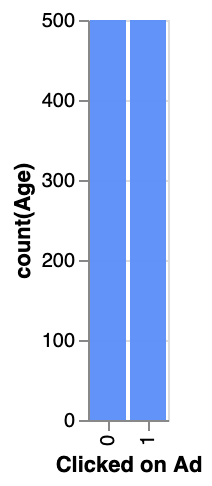
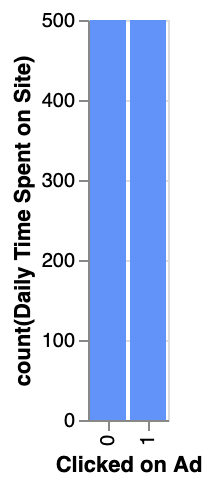
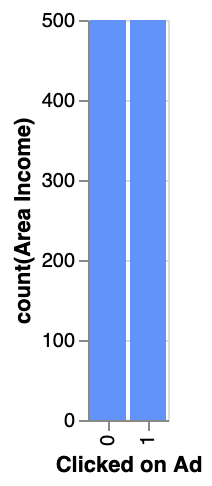
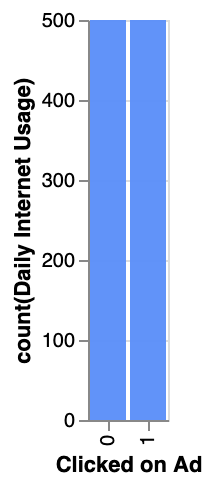

In [33]:
walker = pyg.walk(
    data,
    spec="./chart_meta_overview.json",    # this json file will save your chart state, you need to click save button in ui mannual when you finish a chart, 'autosave' will be supported in the future.
    use_kernel_calc=True,          # set `use_kernel_calc=True`, pygwalker will use duckdb as computing engine, it support you explore bigger dataset(<=100GB).
)

In [34]:
# X.corr()[target_col[0]].sort_values(ascending = False)

In [35]:
y = X[target_col[0]]
X = X.copy().drop(columns=[target_col[0]])
X.shape

(1000, 5)

In [36]:
X_train_original, X_test, y_train_original, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

# The data is imbalanced. Therefore I use smote method to oversample the data
oversample = SMOTE(random_state=0, k_neighbors=5)
X_train_smote, y_train_smote = oversample.fit_resample(X_train_original, y_train_original)

In [37]:
import pickle
import os
path = "models_no_preprocessing"
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(path)
    

In [38]:
import os
def model_performance(model, X_train, y_train, X_test, y_test, model_name="", show_stat=True, use_save_model=True):

    t0 = time.time()
    pickle_file_name = path + "/" + model_name + ".sav"
    
    use_model = model
    if use_save_model and os.path.exists(pickle_file_name):
        use_model = pickle.load(open(pickle_file_name, 'rb'))
    else:
        result = model.fit(X_train, y_train)
        use_model = model
        pickle.dump(model, open(pickle_file_name, 'wb'))
    training_time_seconds = time.time() - t0
    prediction_test = use_model.predict(X_test)
    # Print the prediction accuracy
    # print ("accuracy score: ", accuracy_score(y_test, prediction_test))
    # print ("f1 score: ", f1_score(y_test, prediction_test))


    #confusion matrix
    conf_matrix = confusion_matrix(y_test, prediction_test)
    #roc_auc_score
    model_roc_auc = roc_auc_score(y_test, prediction_test) 
    if show_stat:
        print("Model name: ", model_name)
        print('Algorithm:', type(model).__name__)
        print(classification_report(y_test, prediction_test, digits=4))
        print("Area under the roc curve:", model_roc_auc,"\n")

        ax = sns.heatmap(conf_matrix, annot=True, cmap='Reds', fmt='g')
        ax.set_title('Confusion Matrix\n\n');
        ax.set_xlabel('\nPredicted Values')
        ax.set_ylabel('Actual Values (True Label) ');

        ax.xaxis.set_ticklabels(['Not Clicked on Ad','Clicked on Ad'])
        ax.yaxis.set_ticklabels(['Not Clicked on Ad','Clicked on Ad'])
        plt.show()

        #create ROC curve
        probabilities = use_model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test,  probabilities)
        plt.plot(fpr,tpr)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        plt.show()
        
        # try:

        # # viz = FeatureImportances(model, topn=10)
        #     viz = FeatureImportances(use_model, relative=False)

        #     viz.fit(X_test, y_test)
        #     viz.show()
        # except:
        #     pass
        
    accuracy = accuracy_score(y_test, prediction_test)
    recallscore = recall_score(y_test, prediction_test)
    precision = precision_score(y_test, prediction_test)
    roc_auc = model_roc_auc
    f1score = f1_score(y_test, prediction_test) 
    df = pd.DataFrame({"Model"           : [model_name],
                       "Accuracy"        : [accuracy],
                       "Recall"          : [recallscore],
                       "Precision"       : [precision],
                       "f1-score"        : [f1score],
                       "Roc_auc"         : [roc_auc],
                       "Training Time(s)"         : [training_time_seconds],
                      })
    return df

In [39]:
def ml_classification(show_stat=False):
    performances_df = pd.DataFrame() 
    random_state = 50
    classifiers = []
    lg_params = {'solver': 'liblinear', 'penalty': 'l2', 'C': 69.51927961775606}

    classifiers.append(dict(model=LogisticRegression(max_iter=10000, **lg_params),name='LogisticRegression'))
    
    dt_params = {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5}
    classifiers.append(dict(model=DecisionTreeClassifier(random_state = random_state, splitter = "best", **dt_params), 
                            name='DecisionTreeClassifier'))
    
    rf_params = {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 14} 
    classifiers.append(dict(model=RandomForestClassifier(criterion = "gini", random_state = random_state, **rf_params), 
                        name='RandomForestClassifier'))
    

    classifiers.append(dict(model=SVC(C=2.6, kernel='linear', probability=True, gamma=0.001, random_state=random_state), 
                            name='SVC (linear)'))
    

    classifiers.append(dict(model=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), random_state=random_state,learning_rate=1, n_estimators=50), 
                            name='AdaBoost'))

    num_rfe_features_to_select = 15
    rfe = RFE(LogisticRegression(max_iter=10000), n_features_to_select=num_rfe_features_to_select, step=1)
    rfe = rfe.fit(X_train_original, y_train_original.values.ravel())

    #identified columns Recursive Feature Elimination
    idc_rfe = pd.DataFrame({"rfe_support": rfe.support_,
                            "columns": X_train_original.columns,
                            "ranking": rfe.ranking_,
                           })

    cols_rfe = idc_rfe[idc_rfe["rfe_support"] == True]["columns"].tolist()
    for classifier in classifiers:
        # classifier and fitting
        model = classifier['model']
        name = classifier['name']
        df = model_performance(model, X_train_original, y_train_original, X_test, y_test, name, show_stat=show_stat)
        performances_df = performances_df._append(df)
        
        # name = classifier['name'] + ' (SMOTE)'
        # df = model_performance(model, X_train_smote, y_train_smote, X_test, y_test, name, show_stat=show_stat)
        # performances_df = performances_df._append(df)
        
        ## RFE
        if True: #type(model).__name__ in ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier']:

#             name = classifier['name'] + ' (RFE)'
#             df = model_performance(model, X_train_original[cols_rfe], y_train_original, X_test[cols_rfe], y_test, name, show_stat=show_stat)
#             performances_df = performances_df.append(df)

            ## SMOTE + RFE

            name = classifier['name'] + ' (RFE)'
            df = model_performance(model, X_train_original[cols_rfe], y_train_original, X_test[cols_rfe], y_test, name, show_stat=show_stat)
            performances_df = performances_df._append(df)
        
    return performances_df        
                       

Model name:  LogisticRegression
Algorithm: LogisticRegression
              precision    recall  f1-score   support

           0     0.8807    0.9231    0.9014       104
           1     0.9121    0.8646    0.8877        96

    accuracy                         0.8950       200
   macro avg     0.8964    0.8938    0.8946       200
weighted avg     0.8958    0.8950    0.8948       200

Area under the roc curve: 0.8938301282051284 



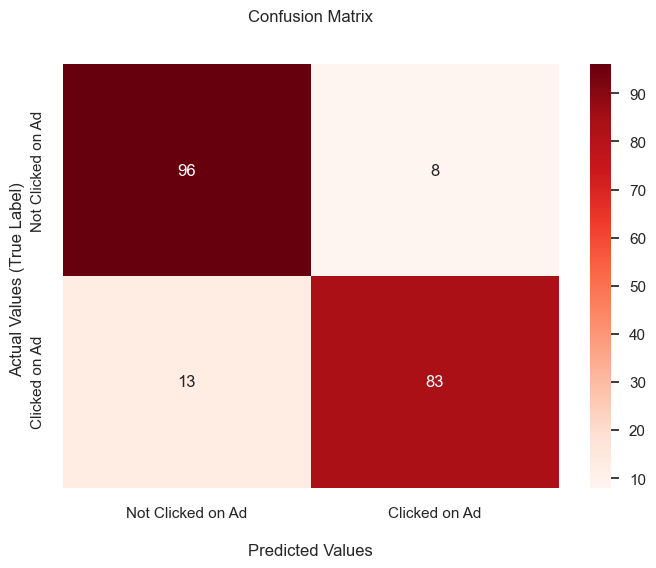

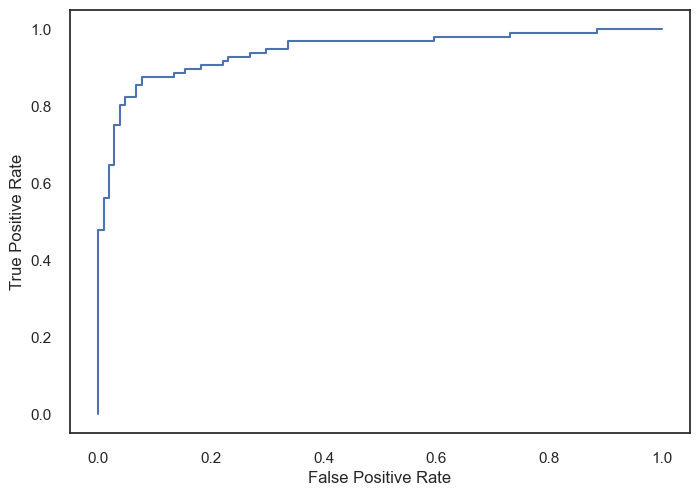

Model name:  LogisticRegression (RFE)
Algorithm: LogisticRegression
              precision    recall  f1-score   support

           0     0.8807    0.9231    0.9014       104
           1     0.9121    0.8646    0.8877        96

    accuracy                         0.8950       200
   macro avg     0.8964    0.8938    0.8946       200
weighted avg     0.8958    0.8950    0.8948       200

Area under the roc curve: 0.8938301282051284 



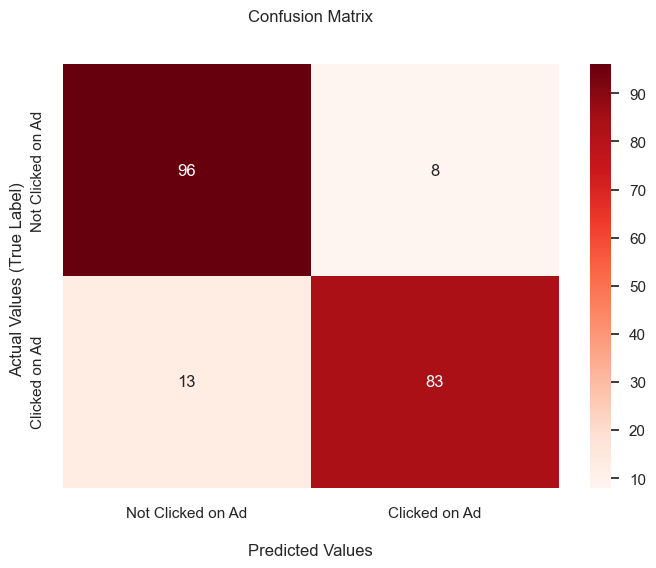

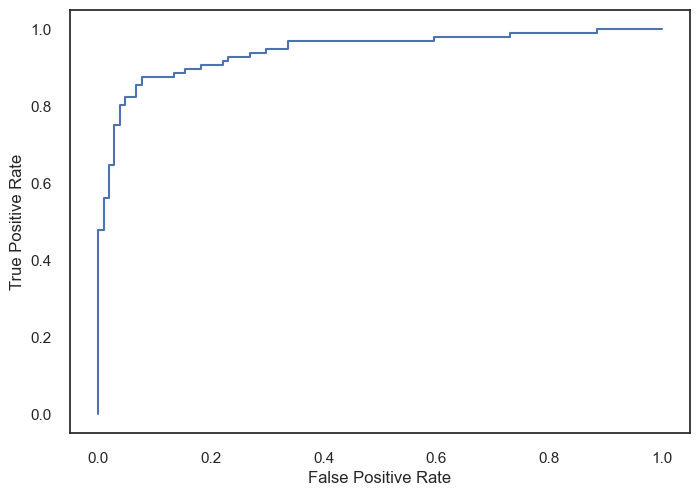

Model name:  DecisionTreeClassifier
Algorithm: DecisionTreeClassifier
              precision    recall  f1-score   support

           0     0.9238    0.9327    0.9282       104
           1     0.9263    0.9167    0.9215        96

    accuracy                         0.9250       200
   macro avg     0.9251    0.9247    0.9248       200
weighted avg     0.9250    0.9250    0.9250       200

Area under the roc curve: 0.9246794871794871 



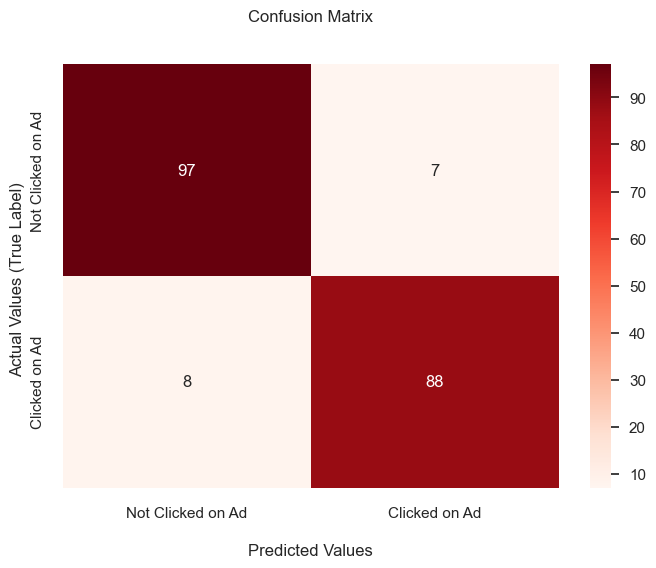

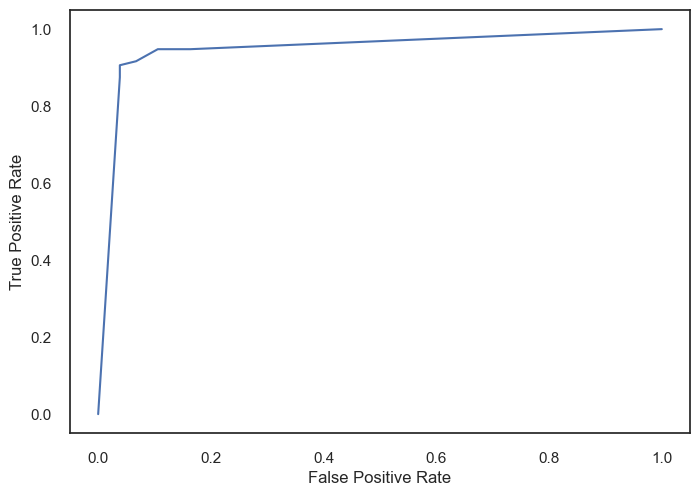

Model name:  DecisionTreeClassifier (RFE)
Algorithm: DecisionTreeClassifier
              precision    recall  f1-score   support

           0     0.9238    0.9327    0.9282       104
           1     0.9263    0.9167    0.9215        96

    accuracy                         0.9250       200
   macro avg     0.9251    0.9247    0.9248       200
weighted avg     0.9250    0.9250    0.9250       200

Area under the roc curve: 0.9246794871794871 



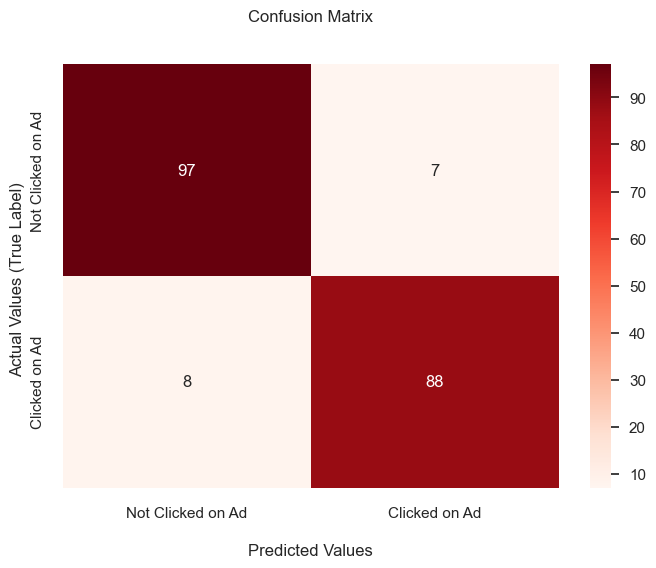

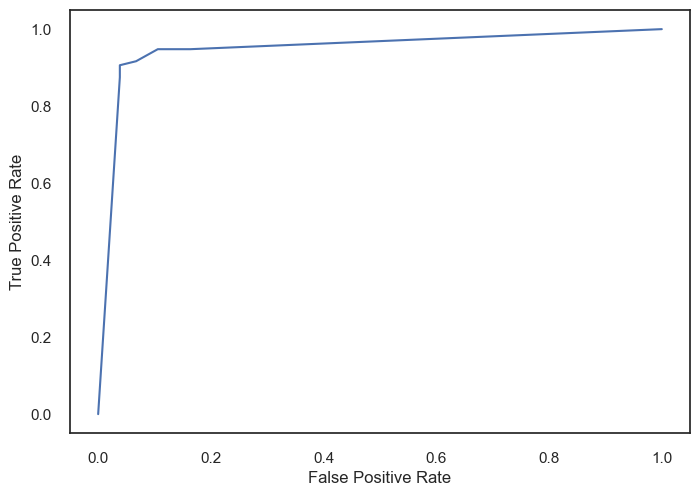

Model name:  RandomForestClassifier
Algorithm: RandomForestClassifier
              precision    recall  f1-score   support

           0     0.9524    0.9615    0.9569       104
           1     0.9579    0.9479    0.9529        96

    accuracy                         0.9550       200
   macro avg     0.9551    0.9547    0.9549       200
weighted avg     0.9550    0.9550    0.9550       200

Area under the roc curve: 0.954727564102564 



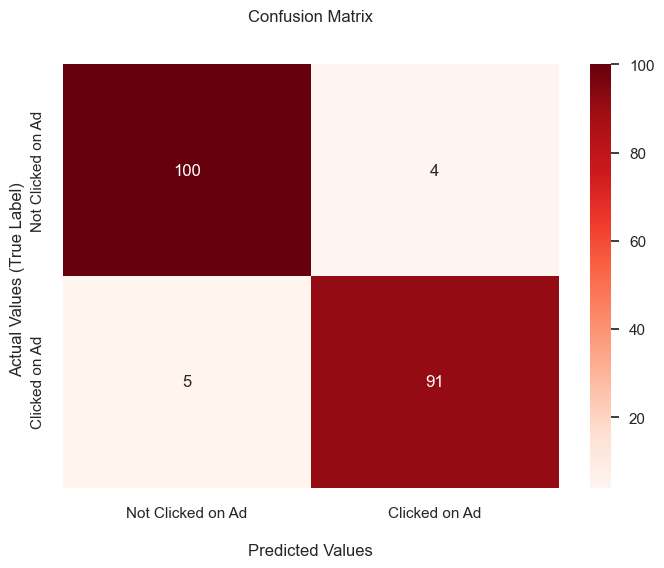

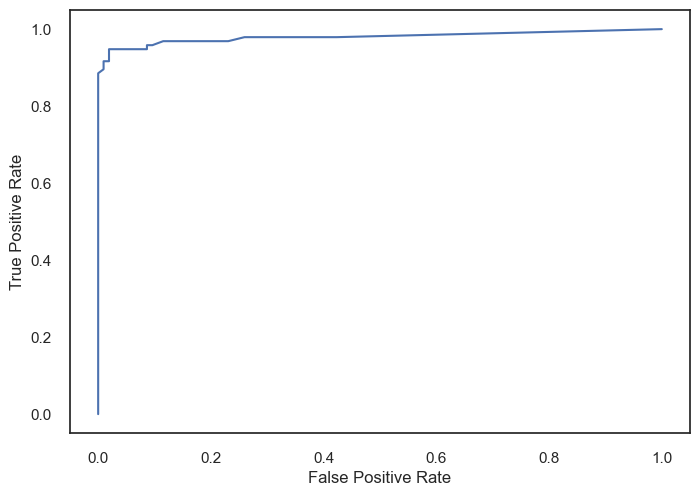

Model name:  RandomForestClassifier (RFE)
Algorithm: RandomForestClassifier
              precision    recall  f1-score   support

           0     0.9524    0.9615    0.9569       104
           1     0.9579    0.9479    0.9529        96

    accuracy                         0.9550       200
   macro avg     0.9551    0.9547    0.9549       200
weighted avg     0.9550    0.9550    0.9550       200

Area under the roc curve: 0.954727564102564 



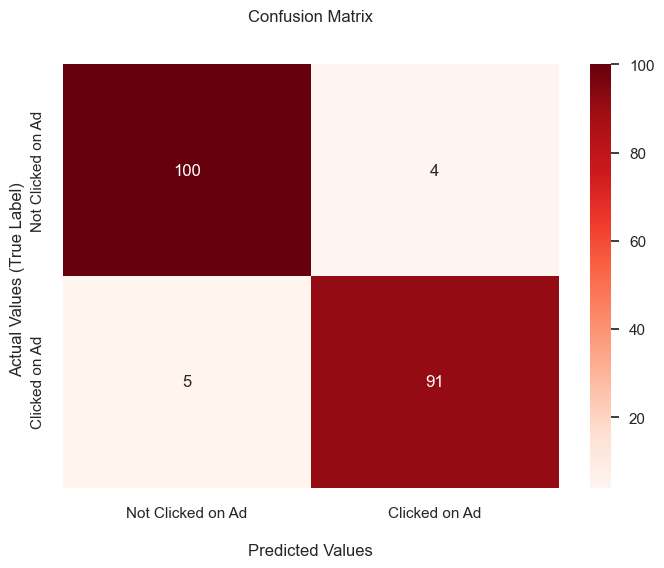

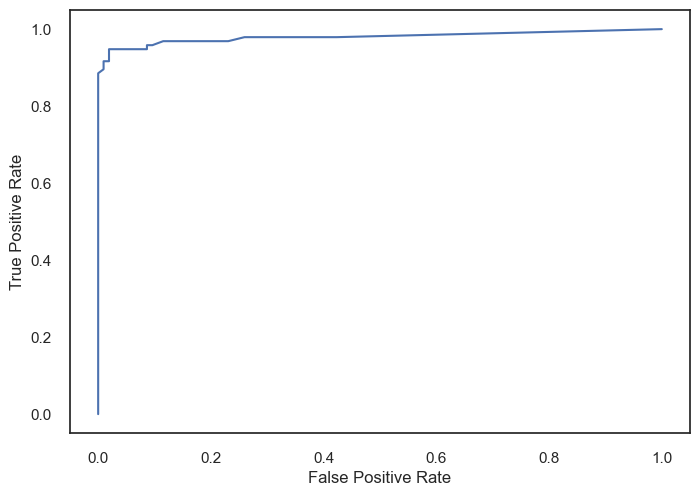

Model name:  SVC (linear)
Algorithm: SVC
              precision    recall  f1-score   support

           0     0.9444    0.9808    0.9623       104
           1     0.9783    0.9375    0.9574        96

    accuracy                         0.9600       200
   macro avg     0.9614    0.9591    0.9599       200
weighted avg     0.9607    0.9600    0.9600       200

Area under the roc curve: 0.9591346153846154 



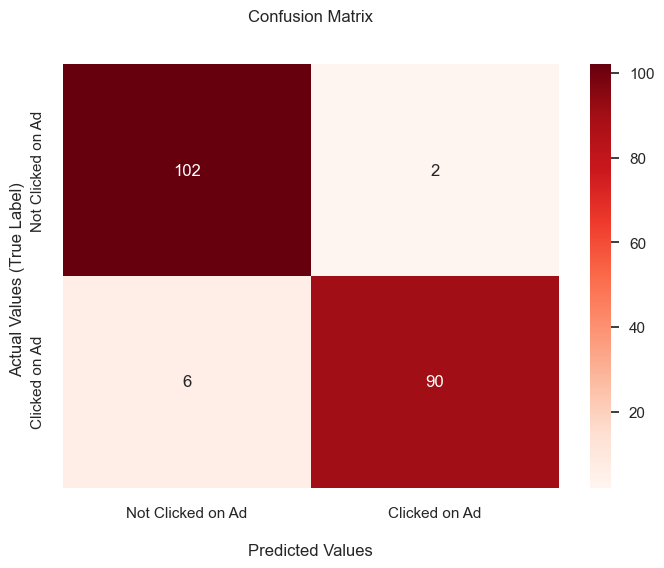

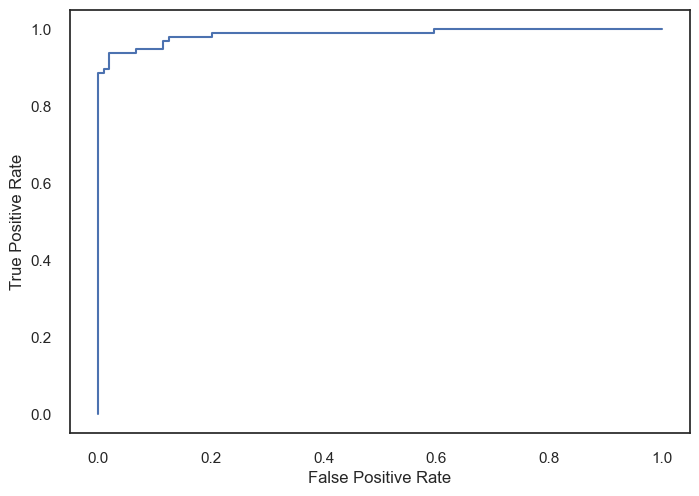

Model name:  SVC (linear) (RFE)
Algorithm: SVC
              precision    recall  f1-score   support

           0     0.9444    0.9808    0.9623       104
           1     0.9783    0.9375    0.9574        96

    accuracy                         0.9600       200
   macro avg     0.9614    0.9591    0.9599       200
weighted avg     0.9607    0.9600    0.9600       200

Area under the roc curve: 0.9591346153846154 



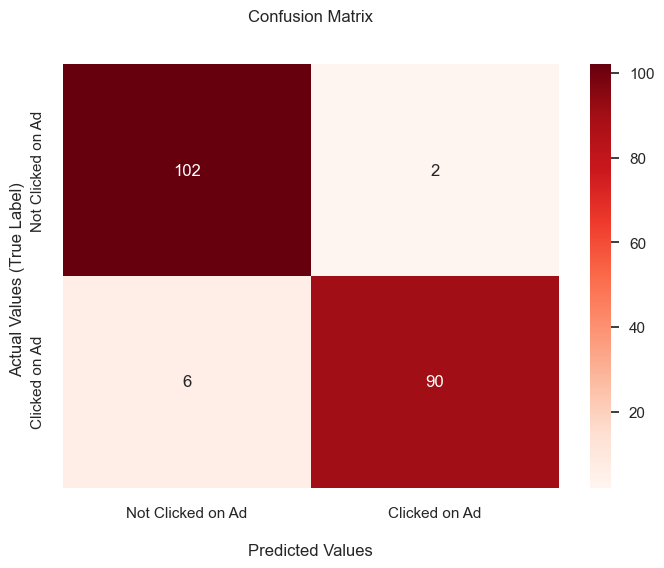

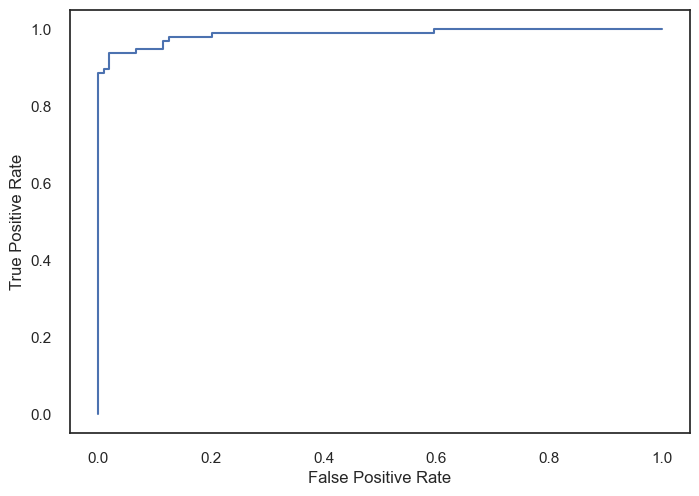

Model name:  AdaBoost
Algorithm: AdaBoostClassifier
              precision    recall  f1-score   support

           0     0.9252    0.9519    0.9384       104
           1     0.9462    0.9167    0.9312        96

    accuracy                         0.9350       200
   macro avg     0.9357    0.9343    0.9348       200
weighted avg     0.9353    0.9350    0.9349       200

Area under the roc curve: 0.9342948717948717 



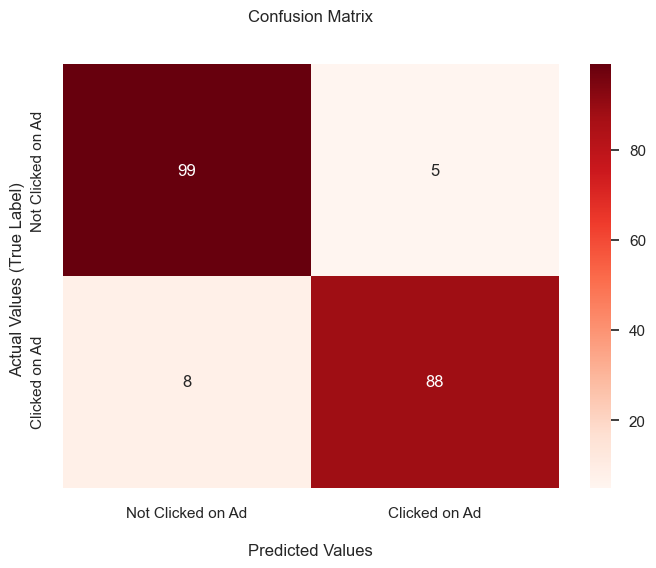

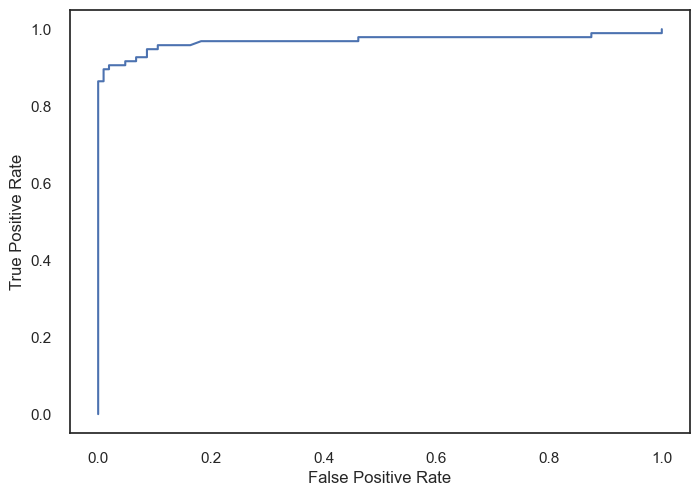

Model name:  AdaBoost (RFE)
Algorithm: AdaBoostClassifier
              precision    recall  f1-score   support

           0     0.9252    0.9519    0.9384       104
           1     0.9462    0.9167    0.9312        96

    accuracy                         0.9350       200
   macro avg     0.9357    0.9343    0.9348       200
weighted avg     0.9353    0.9350    0.9349       200

Area under the roc curve: 0.9342948717948717 



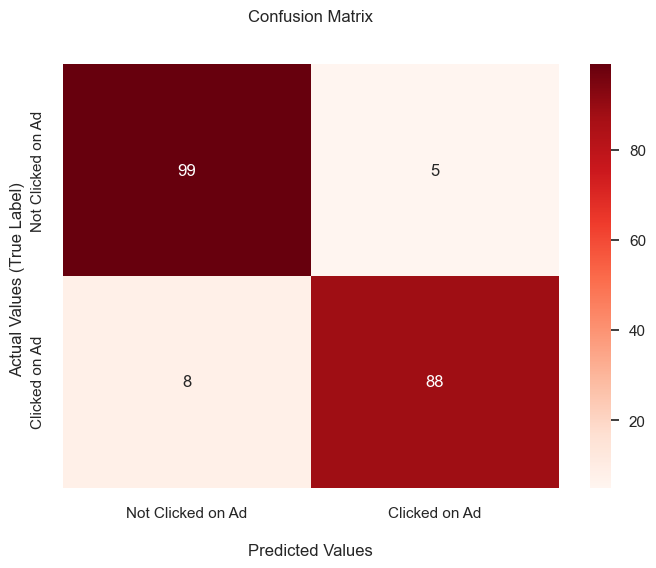

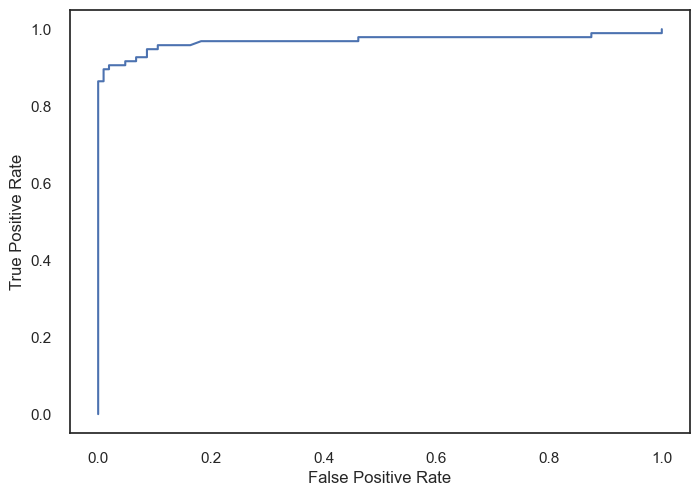

In [40]:
performances_df = ml_classification(show_stat=True)

In [41]:
import plotly.figure_factory as ff # visualization
import plotly.offline as plotly_py # visualization
plotly_py.init_notebook_mode(connected=True) # visualization

# colorscale = [[0, '#4d004c'],[.5, '#f2e5ff'],[1, '#ffffff']]

# table = ff.create_table(np.round(performances_df, 4), colorscale=colorscale)
# table.layout.font.size = 10
# # for i in range(len(table.layout.annotations)):
# #     if i == 0:
# #         table.layout.annotations[i].font.size = 10
# #     else:
# #         table.layout.annotations[i].align = 'left'
# plotly_py.iplot(table)

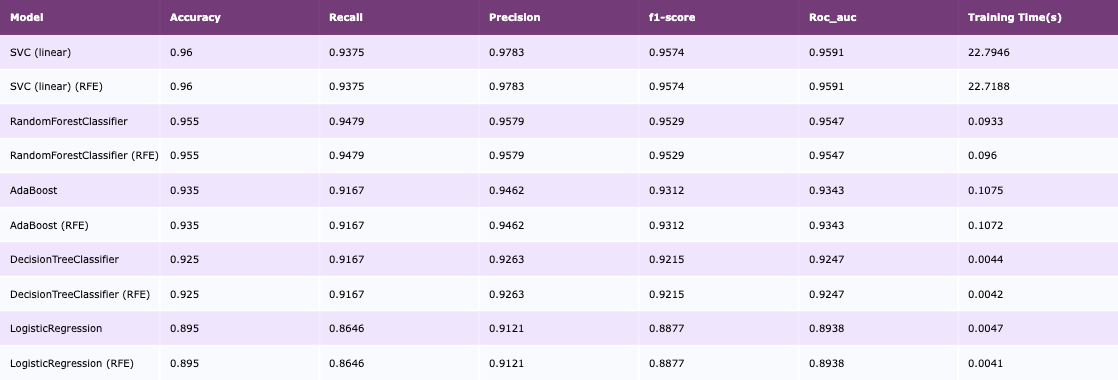

In [42]:
sorted_df = performances_df.sort_values(by=['f1-score'], ascending=False)
colorscale = [[0, '#4d004c'],[.5, '#f2e5ff'],[1, '#ffffff']]

sorted_df.to_csv("models/performance.csv", float_format='%.3f')

table = ff.create_table(np.round(sorted_df, 4), colorscale=colorscale)
table.layout.font.size = 10
# for i in range(len(table.layout.annotations)):
#     if i == 0:
#         table.layout.annotations[i].font.size = 10
#     else:
#         table.layout.annotations[i].align = 'left'
plotly_py.iplot(table)

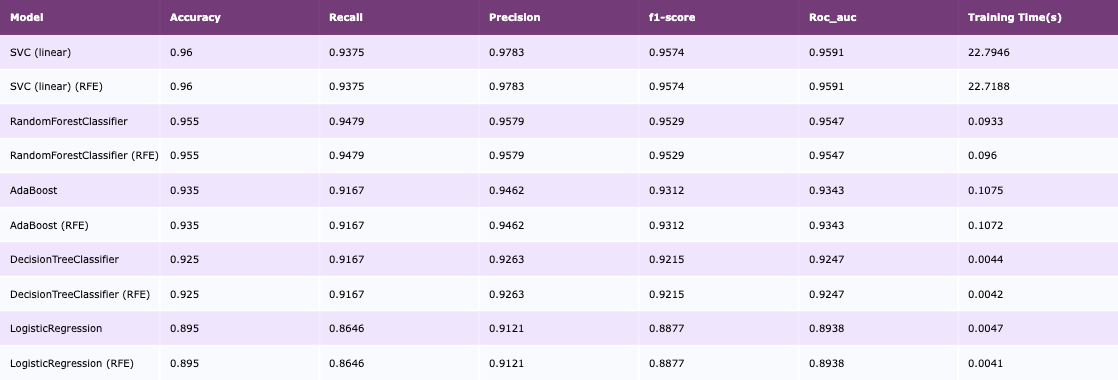

In [43]:
sorted_df = performances_df.sort_values(by=['Roc_auc'], ascending=False)
colorscale = [[0, '#4d004c'],[.5, '#f2e5ff'],[1, '#ffffff']]

table = ff.create_table(np.round(sorted_df, 4), colorscale=colorscale)
table.layout.font.size = 10

# for i in range(len(table.layout.annotations)):
#     if i == 0:
#         table.layout.annotations[i].font.size = 10
#     else:
#         table.layout.annotations[i].align = 'left'
plotly_py.iplot(table)

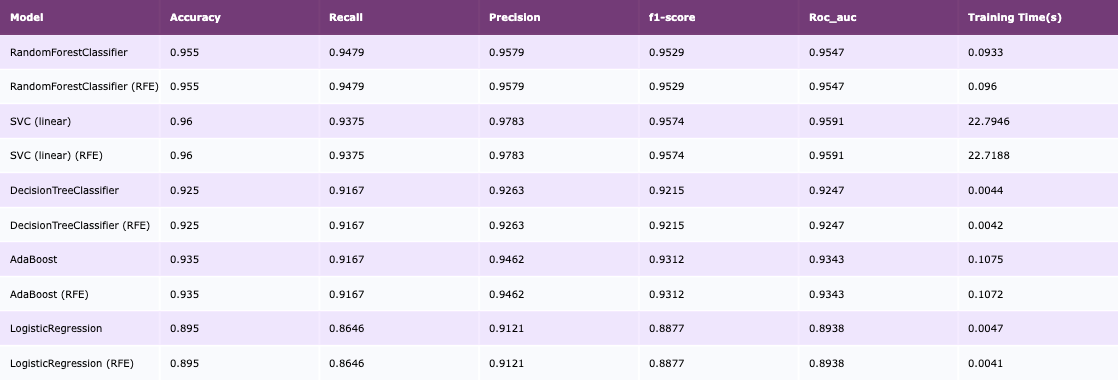

In [44]:
sorted_df = performances_df.sort_values(by=['Recall'], ascending=False)
colorscale = [[0, '#4d004c'],[.5, '#f2e5ff'],[1, '#ffffff']]

table = ff.create_table(np.round(sorted_df, 4), colorscale=colorscale)
table.layout.font.size = 10

# for i in range(len(table.layout.annotations)):
#     if i == 0:
#         table.layout.annotations[i].font.size = 10
#     else:
#         table.layout.annotations[i].align = 'left'
plotly_py.iplot(table)

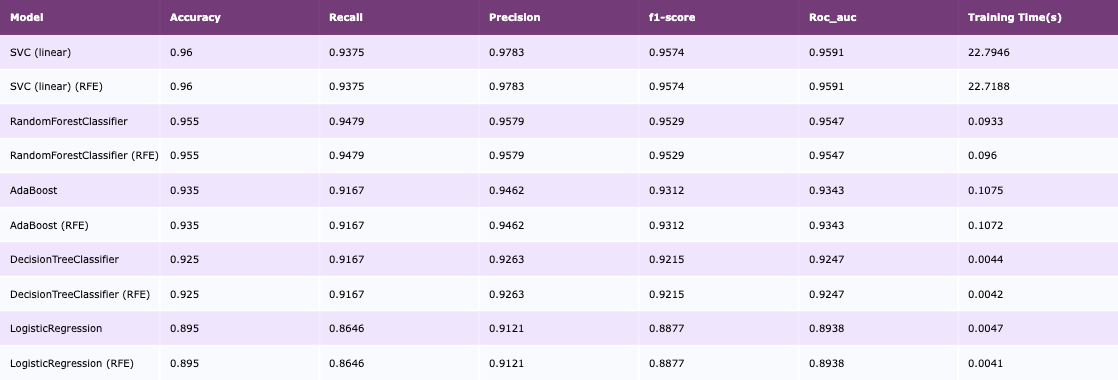

In [45]:
sorted_df = performances_df.sort_values(by=['Accuracy'], ascending=False)
colorscale = [[0, '#4d004c'],[.5, '#f2e5ff'],[1, '#ffffff']]

table = ff.create_table(np.round(sorted_df, 4), colorscale=colorscale)
table.layout.font.size = 10

# for i in range(len(table.layout.annotations)):
#     if i == 0:
#         table.layout.annotations[i].font.size = 10
#     else:
#         table.layout.annotations[i].align = 'left'
plotly_py.iplot(table)

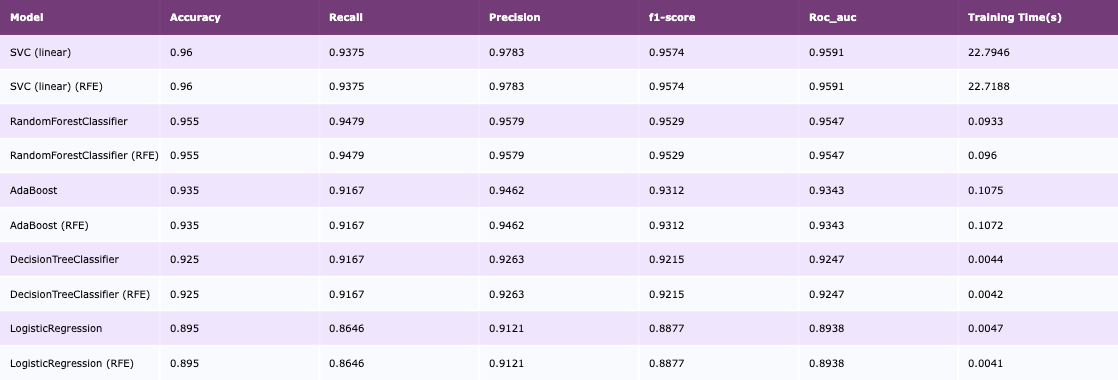

In [46]:
sorted_df = performances_df.sort_values(by=['Precision'], ascending=False)
colorscale = [[0, '#4d004c'],[.5, '#f2e5ff'],[1, '#ffffff']]

table = ff.create_table(np.round(sorted_df, 4), colorscale=colorscale)
table.layout.font.size = 10

# for i in range(len(table.layout.annotations)):
#     if i == 0:
#         table.layout.annotations[i].font.size = 10
#     else:
#         table.layout.annotations[i].align = 'left'
plotly_py.iplot(table)

In [47]:
len(X_test.columns)

5

In [48]:
num_rfe_features_to_select = 15
rfe = RFE(LogisticRegression(max_iter=10000), n_features_to_select=num_rfe_features_to_select, step=1)
rfe = rfe.fit(X_train_original, y_train_original.values.ravel())

#identified columns Recursive Feature Elimination
idc_rfe = pd.DataFrame({"rfe_support": rfe.support_,
                        "columns": X_train_original.columns,
                        "ranking": rfe.ranking_,
                       })

cols_rfe = idc_rfe[idc_rfe["rfe_support"] == True]["columns"].tolist()

In [49]:
cols_rfe

['Male',
 'Daily Time Spent on Site',
 'Age',
 'Area Income',
 'Daily Internet Usage']

In [50]:
performances_df

Model  Accuracy    Recall  Precision  f1-score  \
0            LogisticRegression     0.895  0.864583   0.912088  0.887701   
0      LogisticRegression (RFE)     0.895  0.864583   0.912088  0.887701   
0        DecisionTreeClassifier     0.925  0.916667   0.926316  0.921466   
0  DecisionTreeClassifier (RFE)     0.925  0.916667   0.926316  0.921466   
0        RandomForestClassifier     0.955  0.947917   0.957895  0.952880   
0  RandomForestClassifier (RFE)     0.955  0.947917   0.957895  0.952880   
0                  SVC (linear)     0.960  0.937500   0.978261  0.957447   
0            SVC (linear) (RFE)     0.960  0.937500   0.978261  0.957447   
0                      AdaBoost     0.935  0.916667   0.946237  0.931217   
0                AdaBoost (RFE)     0.935  0.916667   0.946237  0.931217   

    Roc_auc  Training Time(s)  
0  0.893830          0.004741  
0  0.893830          0.004084  
0  0.924679          0.004436  
0  0.924679          0.004220  
0  0.954728          0.093332  
0  0.954728          0.096002  
0  0.959135         22.794648  
0  0.959135         22.718830  
0  0.934295          0.107459  
0  0.934295          0.107189

In [51]:
# 8 rows
exp1_df3 = performances_df[performances_df['Model'].str.contains("RFE") ]
exp1_df3 = exp1_df3.sort_values(by=['f1-score'], ascending=False)
exp1_df3

Model  Accuracy    Recall  Precision  f1-score  \
0            SVC (linear) (RFE)     0.960  0.937500   0.978261  0.957447   
0  RandomForestClassifier (RFE)     0.955  0.947917   0.957895  0.952880   
0                AdaBoost (RFE)     0.935  0.916667   0.946237  0.931217   
0  DecisionTreeClassifier (RFE)     0.925  0.916667   0.926316  0.921466   
0      LogisticRegression (RFE)     0.895  0.864583   0.912088  0.887701   

    Roc_auc  Training Time(s)  
0  0.959135         22.718830  
0  0.954728          0.096002  
0  0.934295          0.107189  
0  0.924679          0.004220  
0  0.893830          0.004084

In [52]:
# 8 rows
exp1_df1 = performances_df[~performances_df['Model'].str.contains("SMOTE") & ~performances_df['Model'].str.contains("RFE")]
exp1_df1 = exp1_df1.sort_values(by=['f1-score'], ascending=False)

exp1_df1

Model  Accuracy    Recall  Precision  f1-score   Roc_auc  \
0            SVC (linear)     0.960  0.937500   0.978261  0.957447  0.959135   
0  RandomForestClassifier     0.955  0.947917   0.957895  0.952880  0.954728   
0                AdaBoost     0.935  0.916667   0.946237  0.931217  0.934295   
0  DecisionTreeClassifier     0.925  0.916667   0.926316  0.921466  0.924679   
0      LogisticRegression     0.895  0.864583   0.912088  0.887701  0.893830   

   Training Time(s)  
0         22.794648  
0          0.093332  
0          0.107459  
0          0.004436  
0          0.004741

In [53]:
num_rfe_features_to_select = 15
rfe = RFE(LogisticRegression(max_iter=10000), n_features_to_select=num_rfe_features_to_select, step=1)
rfe = rfe.fit(X_train_original, y_train_original.values.ravel())

#identified columns Recursive Feature Elimination
idc_rfe = pd.DataFrame({"rfe_support": rfe.support_,
                        "columns": X_train_original.columns,
                        "ranking": rfe.ranking_,
                       })

cols_rfe = idc_rfe[idc_rfe["rfe_support"] == True]["columns"].tolist()
random_state = 50